# **Coloring a planar graph (or a map) with 5 colors**

 **1. Introduction**

The Map Coloring Problem is a classical problem in graph theory. It ask for the minimum number of colors required to color the regions of a map such that no two adjacent regions share the same color. This problem can be modeled using graphs, where vertices represent regions and edges connect regions that share a common border.

Mathematically, coloring a map where countries share borders is identical to coloring a graph where nodes share edges. By transforming the Map Coloring Problem into a graph problem, we can use mathematical tools to study it.


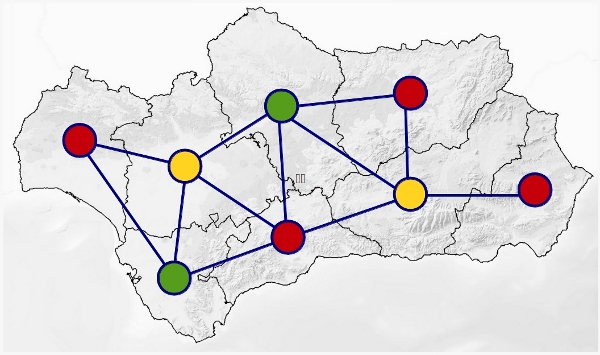

**2. Planar Graphs**

**Definition.** A planar graph is a graph that can be drawn on the plane without any of its edges crossing. This geometric property is what makes efficient coloring possible.

For a connected planar graph with V vertices, E edges and F faces(regions), Euler's Formula states:

                                   V - E + F = 2

**Properties.** From Euler's formula, it follows that for a simple planar graph with V ≥ 3 is:
                                  
                                   E ≤ 3V - 6

This inequality is fundamental for analyzing the degree of vertices, which in turn is essential for graph coloring.

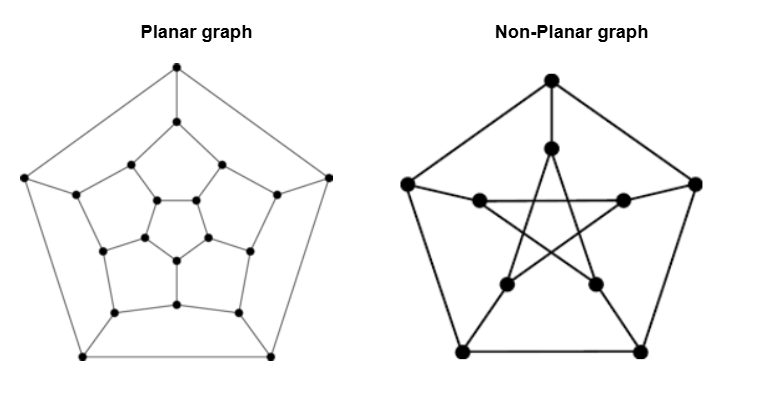


**Graph Coloring Problem.** The vertex coloring problem for planar graphs is defined as:

*   Assigning a color to each vertex
*   In such a way that two adjacent vertices do not have the same color
*   Using the minimum number of colors possible

In terms of maps, this corresponds to assigning colors to regions such that neighboring regions doesn't have the same colors.


**Corollary of Euler's Theorem.** We can prove that every planar graph has at least one vertex of degree ≤ 5.

Suppose every region of the graph has 6 or more neighbors. Then the total number of sides of all faces is at least six times the number of faces. Therefore, E ≥ 6F. Since each edge is a double boundary, we divide by 2, obtaining E ≥ 3F.

At each vertex, three or more sides meet. Therefore, three times the total number of vertices is less than or equal to the total number of sides. Since each side contains two vertices, we divide by 2 and obtain E ≥ 3V.

               2 = V - E + F ≤ V - E + E/3 = V - 2E/3 ≤ V - 2/3 X 3/2V = 0
                                      2 ≤ 0

Contradiction. Therefore, our assumption is false and there is at least one vertex of degree ≤ 5.



**3. Five Color Theorem (Heawood, 1890)**
1. Every planar graph can be colored with ≤ 5 colors.
3. Requirements:
   - Input: A planar graph (G = (V, E))
   - Output: Color assignment (c:V -> {1, 2, 3, 4, 5})
   - Constraint: (∀(u, v) ∈ E : c(u) ≠ c(v))
   - Guarantee: Uses ≤ 5 colors for any planar graph


General idea:
1.   Remove a vertex of degree at most 5
2.   Color the remaining graph recursively
3.   Reinsert the removed vertex
4.   Assign it a color that differs from all of its neighbors. If v has less or 4 neighbors, assign it a free color. If v has exactly 5 neighbors, use another technique.

**Five Neighbors.** If we try to color a central node (v) that has 5 neighbors, we run the risk of each neighbor using a different color. If all 5 available colors are used up by the neighbors, there would be no free colors left for the center.

It is impossible for 5 nodes to all be connected to each other (they would form a non-planar graph). Therefore, we look for two neighbors (x and y) that are not connected.

Once x and y are found, the code merges them into a single temporary node (xy). By converting two neighbors into one, the central node v goes from having 5 neighbors to having 4 neighbors.

With only 4 virtual neighbors, the algorithm knows it is safe to temporarily remove the central node and push it onto the stack. The merged node xy is assigned a color (for example, red). Unmerging the merge forces both x and y to be red. Looking at the central node v, although it has 5 physical neighbors, there are only 4 colors (because red is repeated in x and y). This guarantees that the 5th color is always free to be assigned to v.



**4. Implementation**

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

class Graph:
    def __init__(self, graph=None):
        if graph is None:
            graph = {}
        self.graph = graph.copy()
        # Track all original nodes to ensure they all get colored at the end
        self.original_nodes = set(graph.keys())

    def add_vertex(self, vertex):
        if vertex not in self.graph:
            self.graph[vertex] = []
            self.original_nodes.add(vertex)

    def add_edge(self, edge):
        u, v = edge
        if u == v:
            raise ValueError("Loops are not allowed!")
        self.add_vertex(u)
        self.add_vertex(v)
        if v not in self.graph[u]:
            self.graph[u].append(v)
        if u not in self.graph[v]:
            self.graph[v].append(u)

    def degree(self, v):
        return len(self.graph[v]) #n of neigh

    def are_adjacent(self, u, v):
        return v in self.graph[u]

    def remove_vertex(self, v):
        #we visit each neighbor from u to v
        for u in self.graph[v]:
            self.graph[u].remove(v) #remove v of the list 
        del self.graph[v] #remove v of the graph

    def merge_vertices(self, x, y, new_name):
        """
        Merges two vertices x and y into a new vertex 'new_name'.
        """
        # Combine neighbors from both nodes
        neighbors = set(self.graph[x]) | set(self.graph[y])
        # Remove x and y themselves from the neighbor set (avoid self-loops)
        neighbors.discard(x)
        neighbors.discard(y)

        # Remove original nodes
        self.remove_vertex(x)
        self.remove_vertex(y)

        # Add the new merged node and connect it to all combined neighbors
        self.add_vertex(new_name)
        for u in neighbors:
            self.add_edge([new_name, u])

    def reduce_graph(self):
        """
        Reduces the graph recursively for the 5-color algorithm.
        Returns a stack containing the reconstruction steps.
        """
        stack = []
        #Work on a copy to preserve the original structure for the final drawing
        graph_copy = Graph({v: list(n) for v, n in self.graph.items()})

        while graph_copy.graph: #while there are v
            found_vertex = False
            for v in list(graph_copy.graph.keys()):
                deg = graph_copy.degree(v) #count the neighbors

                # Case 1: Vertex has degree <= 4
                if deg <= 4:
                    #push to stack with current neighbors 
                    stack.append(("single", v, list(graph_copy.graph[v])))
                    print(f"PUSH SINGLE: {v}, neighbors: {graph_copy.graph[v]}")
                    graph_copy.remove_vertex(v)
                    found_vertex = True
                    break

                #Case 2: Vertex has degree 5
                elif deg == 5:
                    neighbors = graph_copy.graph[v]
                    merged = False
                    #Find two neighbors that are NOT adjacent (guaranteed in planar graphs without K5)
                    for i in range(5):
                        for j in range(i + 1, 5):
                            x, y = neighbors[i], neighbors[j]

                            if not graph_copy.are_adjacent(x, y):
                                xy = f"{x}_{y}" # Name of the merged node
                                # Save the "pair" instruction to the stack
                                stack.append(("pair", v, x, y, xy, list(graph_copy.graph[v]))) #x and y same color
                                print(f"PUSH PAIR: v={v}, x={x}, y={y}, xy={xy}, neighbors={graph_copy.graph[v]}")

                                #Remove v
                                graph_copy.remove_vertex(v)
                                #merge x and y
                                graph_copy.merge_vertices(x, y, xy)
                                print(f"MERGE: {x} + {y} => {xy}, merged neighbors: {graph_copy.graph[xy]}")
                                merged = True
                                break
                        if merged:
                            break
                    if merged:
                        found_vertex = True
                        break

            if not found_vertex:
                #Fallback: If no suitable vertex is found (should not happen in planar graphs),
                #pick an arbitrary node to continue.
                v = next(iter(graph_copy.graph))
                stack.append(("single", v, list(graph_copy.graph[v])))
                print(f"PUSH FALLBACK SINGLE: {v}, neighbors: {graph_copy.graph[v]}")
                graph_copy.remove_vertex(v)

        print("\nFINAL STACK (Reduction phase):")
        for item in stack:
            print(item)
        return stack

    def five_color(self):
        """
        Implementation of the 5-color algorithm using the stack.
        Returns a dictionary with colors assigned to all original nodes.
        """
        stack = self.reduce_graph() #instructions 
        colors = {}
        available_colors = {1, 2, 3, 4, 5}

        while stack:
            item = stack.pop() #LIFO

            # Handling standard nodes (degree <= 4)
            if item[0] == "single":
                _, v, neighbors = item
                used = {colors[u] for u in neighbors if u in colors} #colors used
                free = available_colors - used
                if not free:
                    raise RuntimeError(f"No color available for node {v}")
                colors[v] = min(free)

            # Handling identified/merged nodes (degree 5 case)
            else:
                _, v, x, y, xy, neighbors = item

                #Safety check: If the merged node xy hasn't been colored yet, assign one now
                if xy not in colors:
                    used_xy = {colors[u] for u in neighbors if u in colors}
                    free = available_colors - used_xy
                    if not free:
                        raise RuntimeError(f"No color available for merged node {xy}")
                    colors[xy] = min(free)

                #The original nodes x and y inherit the SAME color from xy
                colors[x] = colors[xy]
                colors[y] = colors[xy]

                #Remove the temporary merged node from the colors dict
                del colors[xy]

                #Assign color to v
                #Since x and y share a color, v sees at most 4 colors, leaving the 5th free.
                used_v = {colors[u] for u in neighbors if u in colors}
                free = available_colors - used_v
                if not free:
                    raise RuntimeError(f"No color available for node {v}")
                colors[v] = min(free)

        #Ensure all original nodes have a color (default to 1 if isolated)
        for node in self.original_nodes:
            colors.setdefault(node, 1)

        return colors

    #Visualization
    def draw(self, colors=None):
        nx_graph = nx.Graph()
        for v, neighbors in self.graph.items():
            for u in neighbors:
                nx_graph.add_edge(v, u)

        pos = nx.spring_layout(nx_graph, seed=42)
        if colors:
            #Map numbers to actual color names for plotting
            color_map = {1:'red', 2:'blue', 3:'green', 4:'orange', 5:'purple'}
            node_colors = [color_map.get(colors.get(node, 0), 'gray') for node in nx_graph.nodes()]
        else:
            node_colors = 'lightblue'

        plt.figure(figsize=(6,4))
        nx.draw(nx_graph, pos, with_labels=True, node_color=node_colors, node_size=800,
                font_color='white', font_weight='bold')
        plt.show()


In [3]:
def is_planar(graph: Graph) -> bool:
    """
    Check if a graph is planar using NetworkX.
    graph: instance of your Graph class
    return: True if planar, False otherwise
    """
    G = nx.Graph()
    for u, neighbors in graph.graph.items():
        for v in neighbors:
            if not G.has_edge(u, v):
                G.add_edge(u, v)
    planar, _ = nx.check_planarity(G)
    return planar

## **First example**

In [9]:
#IF IT IS NOT PLANAR IT SHOULD ADVICE
g2 = Graph()
edges_planar = [
    ("A", "B"), ("A", "C"), ("A", "D"), ("A", "E"),
    ("B", "C"), ("B", "D"), ("B", "E"),
    ("C", "D"), ("C", "E"),
    ("D", "E")
]
for u, v in edges_planar:
    g2.add_edge([u, v])

if not is_planar(g2):
    raise ValueError("The graph is not planar, therefore five_color cannot be applied")
colors2 = g2.five_color()
print("Asigned colors:", colors2)

g2.draw(colors2)

ValueError: The graph is not planar, therefore five_color cannot be applied

## **Second example**

PUSH SINGLE: A, neighbors: ['B', 'E']
PUSH SINGLE: B, neighbors: ['C']
PUSH SINGLE: C, neighbors: ['D']
PUSH SINGLE: D, neighbors: ['E']
PUSH SINGLE: E, neighbors: []

FINAL STACK (Reduction phase):
('single', 'A', ['B', 'E'])
('single', 'B', ['C'])
('single', 'C', ['D'])
('single', 'D', ['E'])
('single', 'E', [])
{'E': 1, 'D': 2, 'C': 1, 'B': 2, 'A': 3}


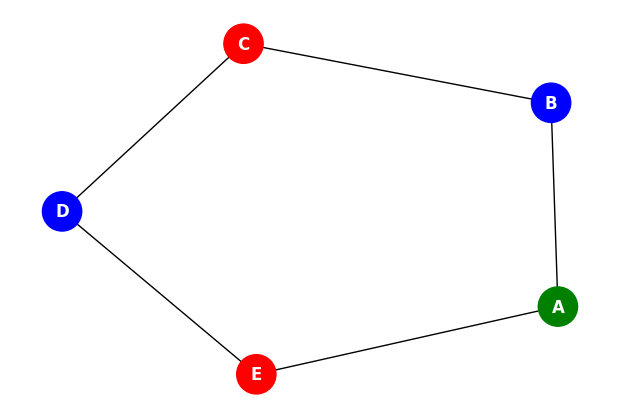

In [10]:
g = Graph()
edges = [('A','B'),('B','C'),('C','D'),('D','E'),('E','A')]
for u,v in edges:
    g.add_edge([u,v])

if not is_planar(g):
    raise ValueError("The graph is not planar, therefore five_color cannot be applied")

colors = g.five_color()
print(colors)
g.draw(colors)


**STEP BY STEP**

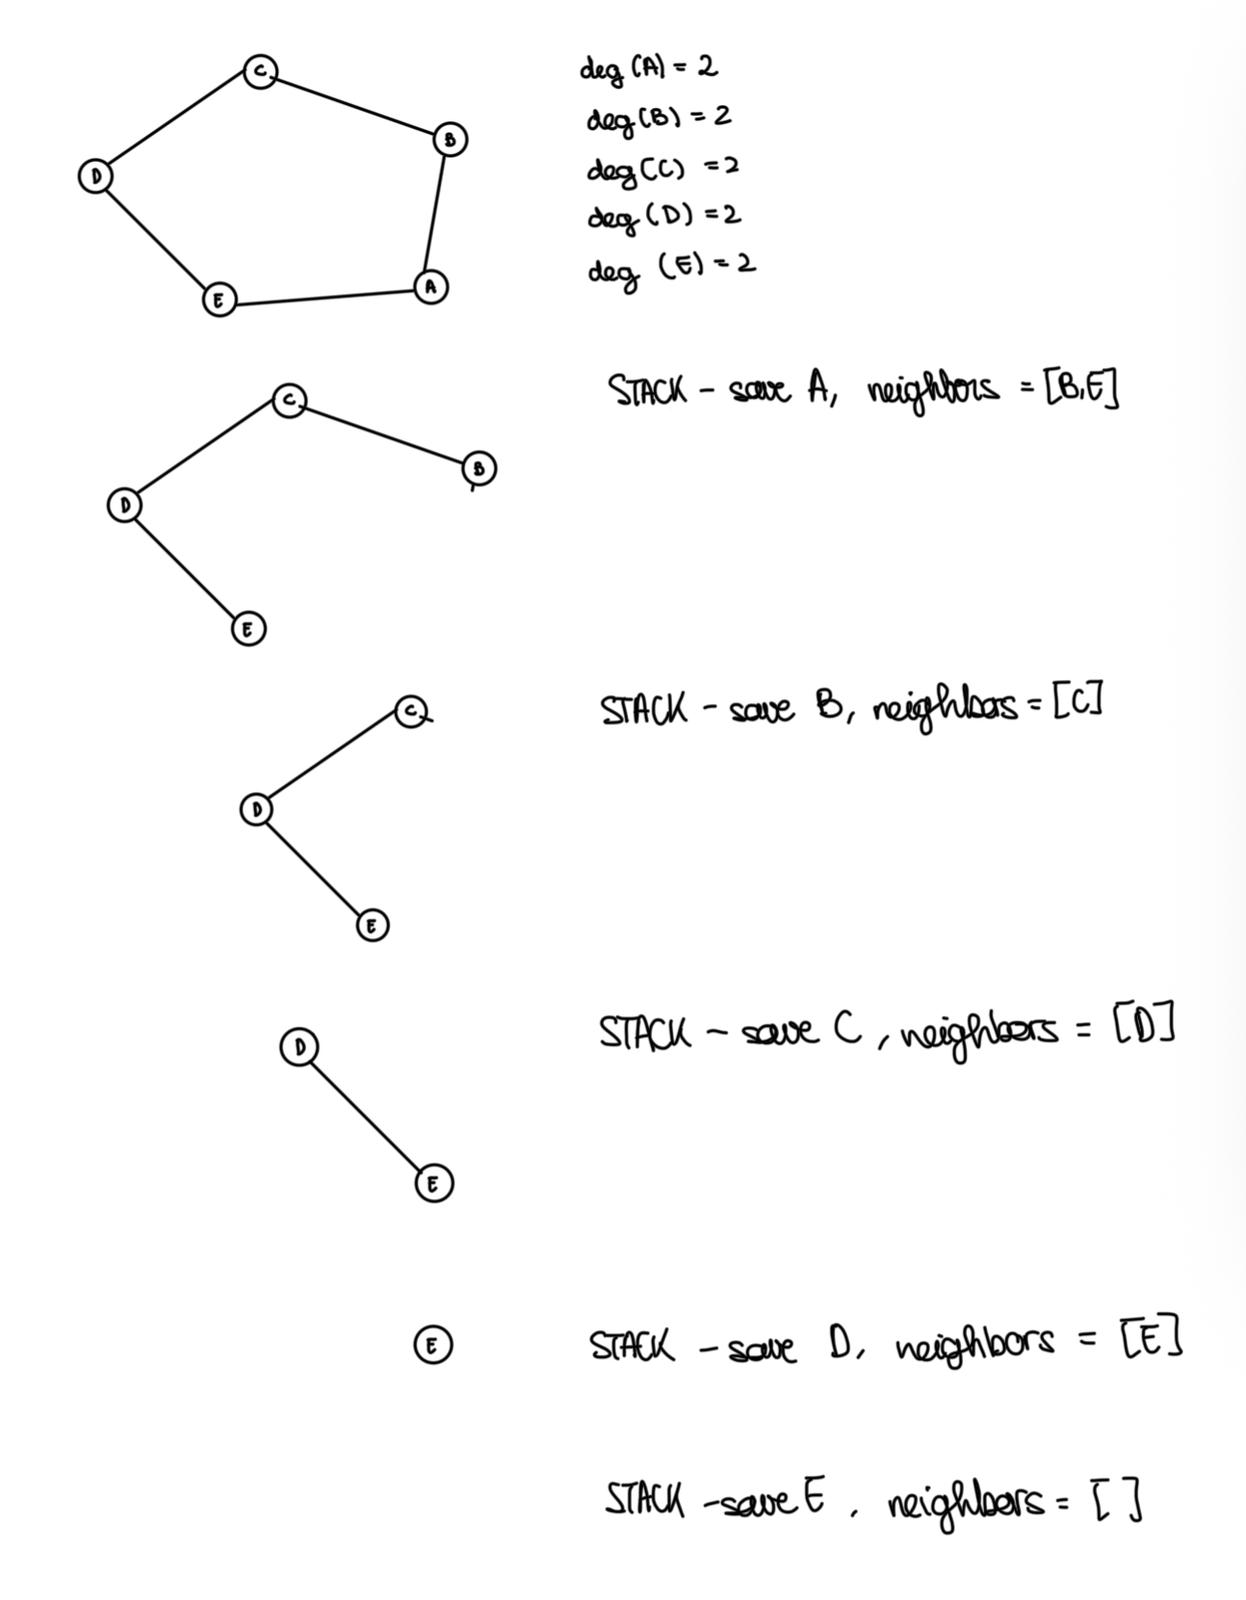

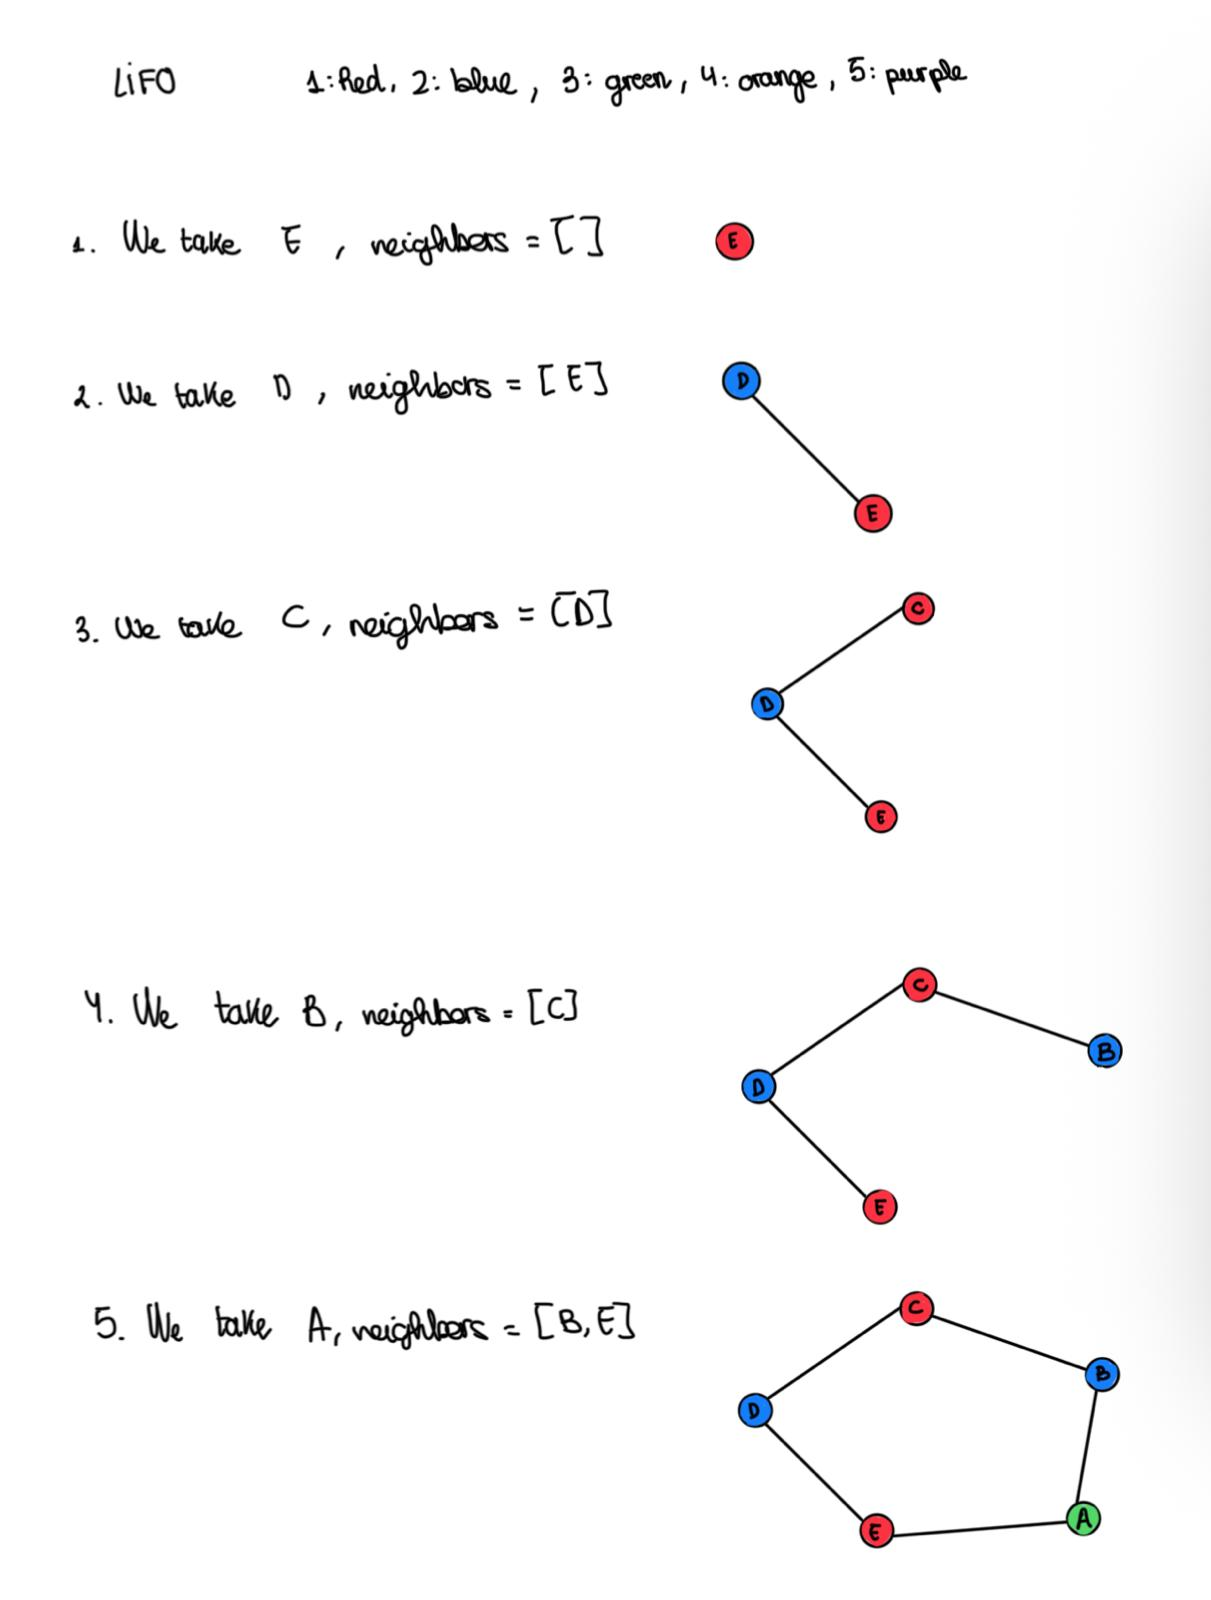

## **Third example**

PUSH PAIR: v=O, x=A, y=C, xy=A_C, neighbors=['A', 'B', 'C', 'D', 'E']
MERGE: A + C => A_C, merged neighbors: ['B', 'D']
PUSH SINGLE: B, neighbors: ['A_C']
PUSH SINGLE: D, neighbors: ['E', 'A_C']
PUSH SINGLE: E, neighbors: []
PUSH SINGLE: A_C, neighbors: []

FINAL STACK (Reduction phase):
('pair', 'O', 'A', 'C', 'A_C', ['A', 'B', 'C', 'D', 'E'])
('single', 'B', ['A_C'])
('single', 'D', ['E', 'A_C'])
('single', 'E', [])
('single', 'A_C', [])
{'E': 1, 'D': 2, 'B': 2, 'A': 1, 'C': 1, 'O': 3}


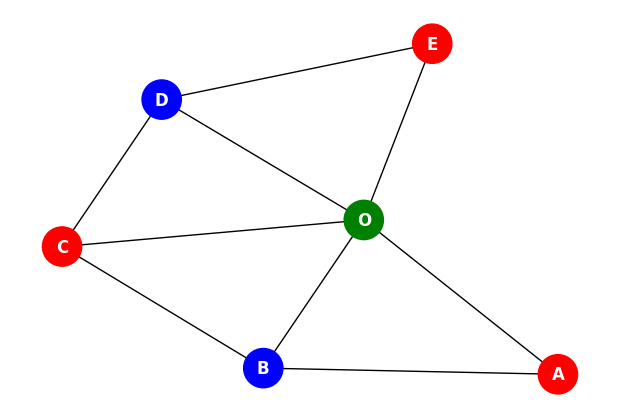

In [11]:
g = Graph()
edges = [
    ('O','A'),('O','B'),('O','C'),('O','D'),('O','E'),
    ('A','B'),('B','C'),('C','D'),('D','E')
]
for u,v in edges:
    g.add_edge([u,v])

if not is_planar(g):
    raise ValueError("The graph is not planar, therefore five_color cannot be applied")

colors = g.five_color()
print(colors)
g.draw(colors)


**STEP BY STEP**


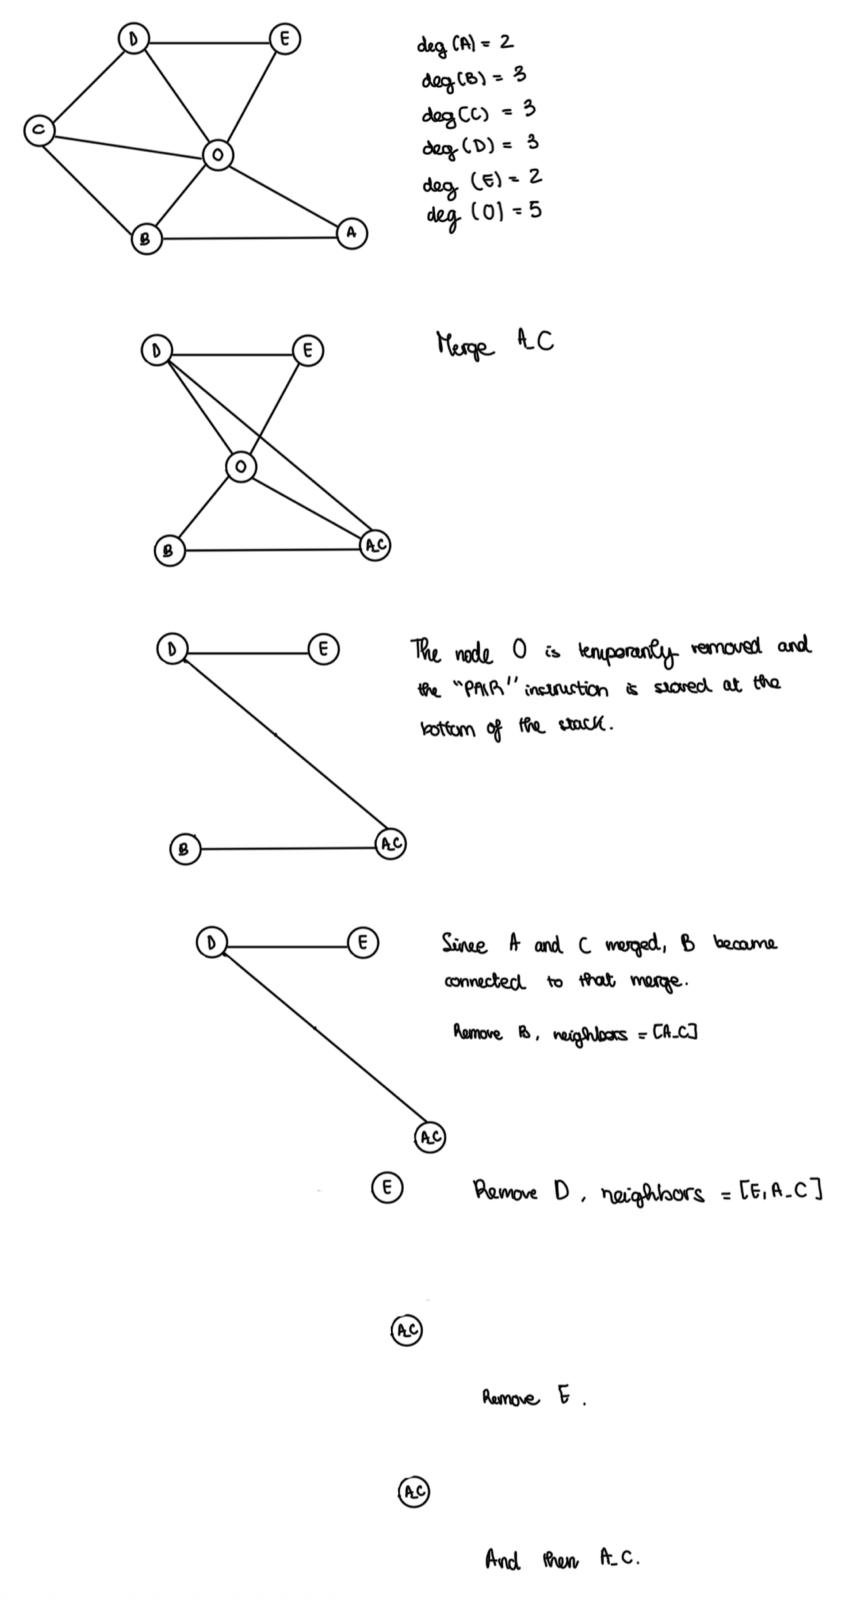

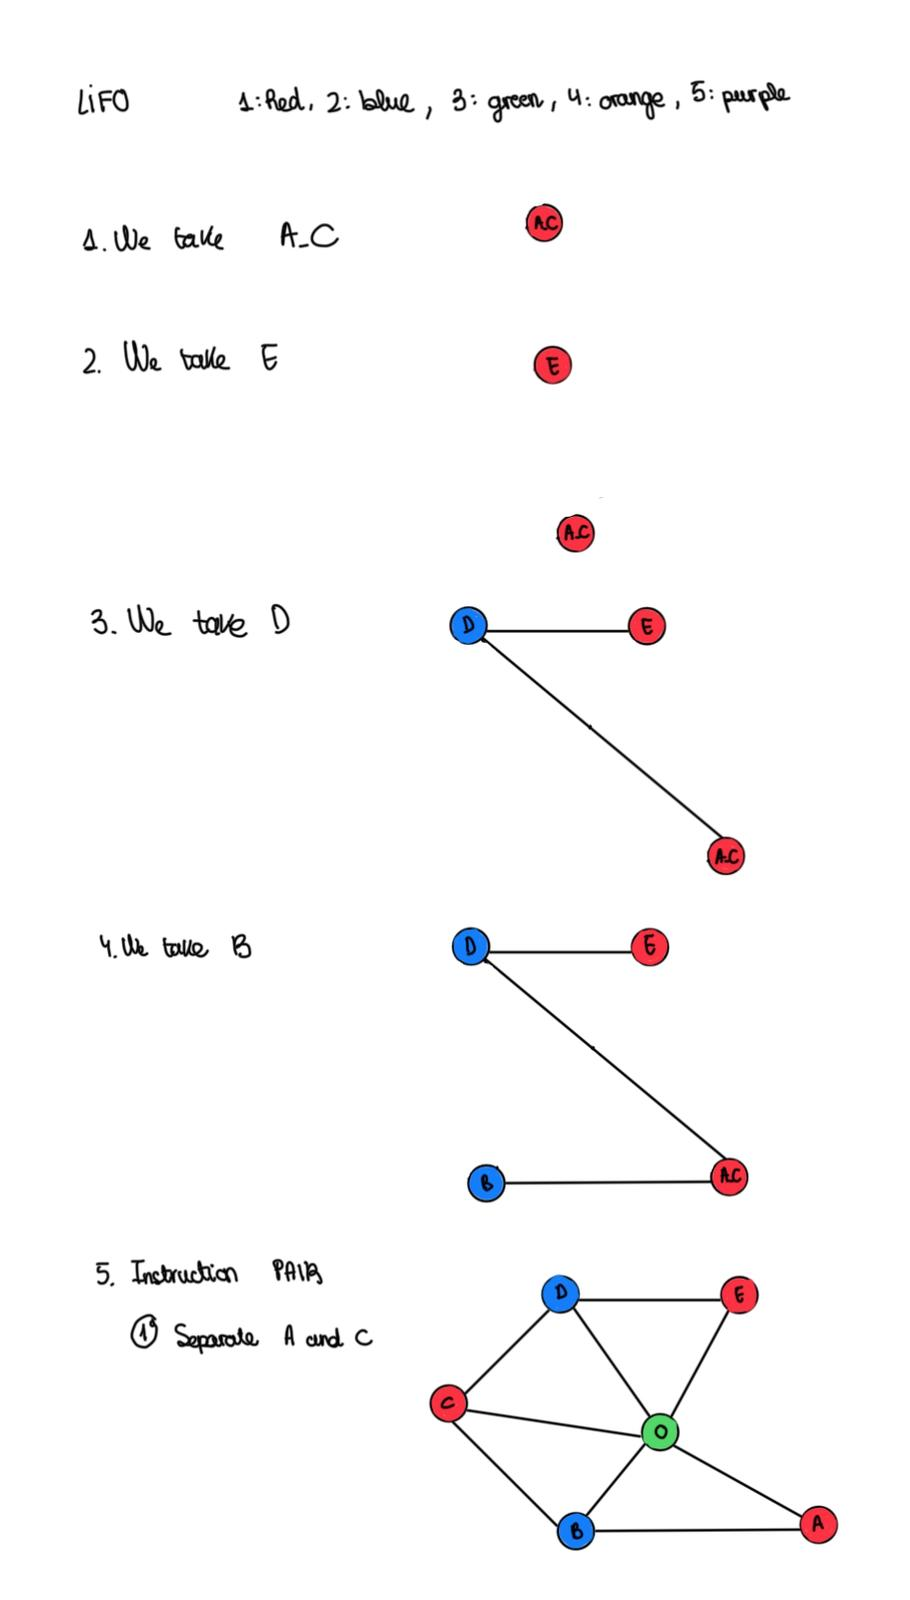

## **Fourth example**

PUSH SINGLE: A, neighbors: ['B', 'C', 'D']
PUSH SINGLE: B, neighbors: ['C', 'D']
PUSH SINGLE: C, neighbors: ['D']
PUSH SINGLE: D, neighbors: []

FINAL STACK (Reduction phase):
('single', 'A', ['B', 'C', 'D'])
('single', 'B', ['C', 'D'])
('single', 'C', ['D'])
('single', 'D', [])
{'D': 1, 'C': 2, 'B': 3, 'A': 4}


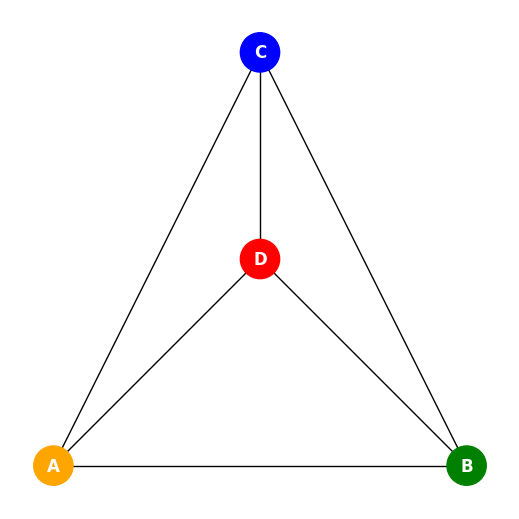

In [12]:
# Crear K4
g = Graph()
nodes = ['A','B','C','D']
for i in range(4):
    for j in range(i+1,4):
        g.add_edge([nodes[i], nodes[j]])

#Coloring using 5 colors
colors = g.five_color()
print(colors)

#Manual positions to make it planar
pos = {
    'A': (0, 0),
    'B': (1, 0),
    'C': (0.5, 1),
    'D': (0.5, 0.5)
}

#Visualization
G = nx.Graph()
for v, neighbors in g.graph.items():
    for u in neighbors:
        G.add_edge(v, u)

if not is_planar(g):
    raise ValueError("The graph is not planar, therefore five_color cannot be applied")

cmap = {1:'red', 2:'blue', 3:'green', 4:'orange', 5:'purple'}
node_colors = [cmap.get(colors.get(v,0), 'gray') for v in G.nodes()]

plt.figure(figsize=(5,5))
nx.draw(G, pos, with_labels=True, node_color=node_colors,
        node_size=800, font_color='white', font_weight='bold')
plt.show()


**STEP BY STEP**

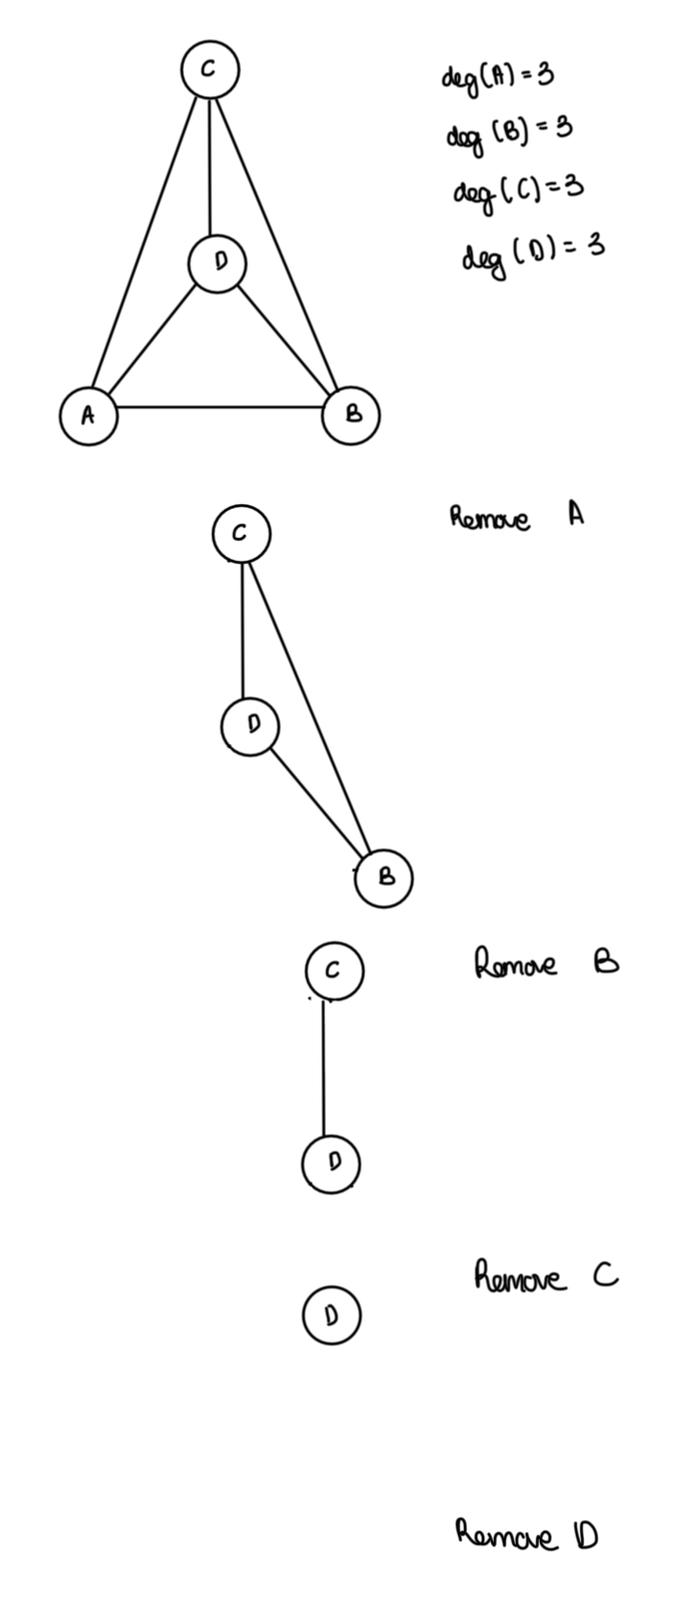

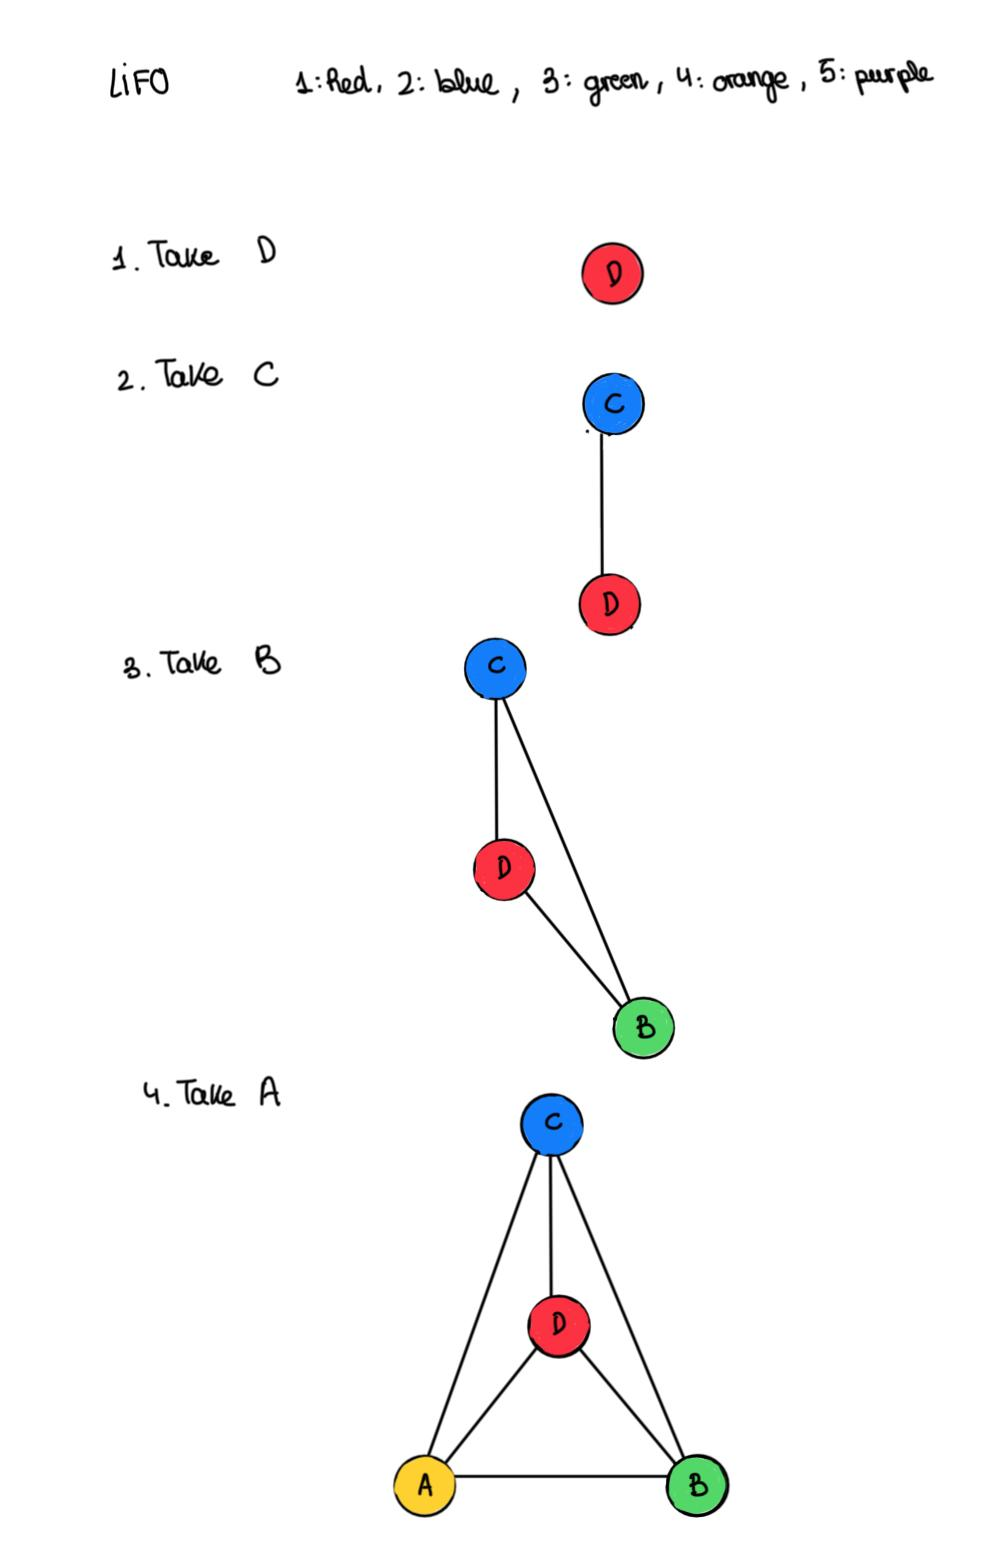

## **Fifth example**

PUSH PAIR: v=O, x=A, y=B, xy=A_B, neighbors=['A', 'B', 'C', 'D', 'E']
MERGE: A + B => A_B, merged neighbors: []
PUSH SINGLE: C, neighbors: []
PUSH SINGLE: D, neighbors: []
PUSH SINGLE: E, neighbors: []
PUSH SINGLE: A_B, neighbors: []

FINAL STACK (Reduction phase):
('pair', 'O', 'A', 'B', 'A_B', ['A', 'B', 'C', 'D', 'E'])
('single', 'C', [])
('single', 'D', [])
('single', 'E', [])
('single', 'A_B', [])
Colors: {'E': 1, 'D': 1, 'C': 1, 'A': 1, 'B': 1, 'O': 2}


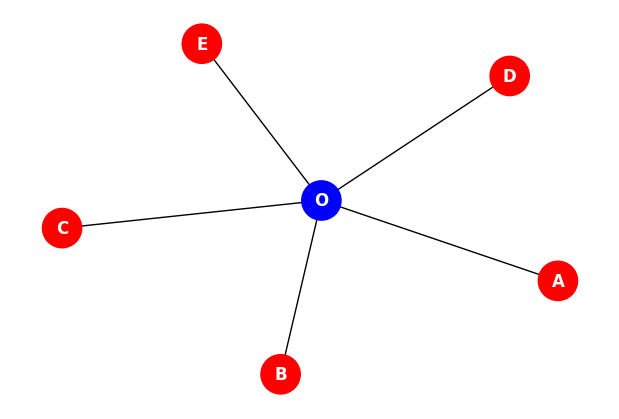

In [13]:
g = Graph()
edges = [('O','A'),('O','B'),('O','C'),('O','D'),('O','E')]
for u,v in edges:
    g.add_edge([u,v])

if not is_planar(g):
    raise ValueError("The graph is not planar, therefore five_color cannot be applied")

colors = g.five_color()
print("Colors:", colors)
g.draw(colors)


## **Conclusion**

Through the implemetation of the reduction and vertex merging algorithm, we have visualized the logic behind the theorem. In this way we see that every planar graph can be colored with at most 5 colors without adjacent vertices sharing the same color.